## Import

In [1]:
import pandas as pd
import warnings;warnings.filterwarnings(action='ignore')

## Read data

In [2]:
data = pd.read_parquet('../data/DataCleansing.pqt')

In [3]:
seat = data.drop_duplicates('seat_label').set_index('seat_label').sort_index()[['층','블록','열','좌석번호']]
seat

층 블록  열 좌석번호
seat_label                
0             1  A  1    1
1             1  A  1    2
2             1  A  1    3
3             1  A  1    4
4             1  A  1    5
...         ... .. ..  ...
2504        합창석  H  4    5
2505        합창석  H  4    6
2506        합창석  H  4    7
2507        합창석  H  4    8
2508        합창석  H  4    9

[2509 rows x 4 columns]

### 콘서트홀 구조
- [참고] https://m.blog.naver.com/sohyeppy/222610113033
- [참고] https://m.blog.naver.com/sohyeppy/222583379685

#### $\blacktriangleright$ 층

In [4]:
seat = pd.concat([seat, pd.get_dummies(seat['층'], dtype=int, prefix='층')], axis=1)

#### $\blacktriangleright$ 블록<br>
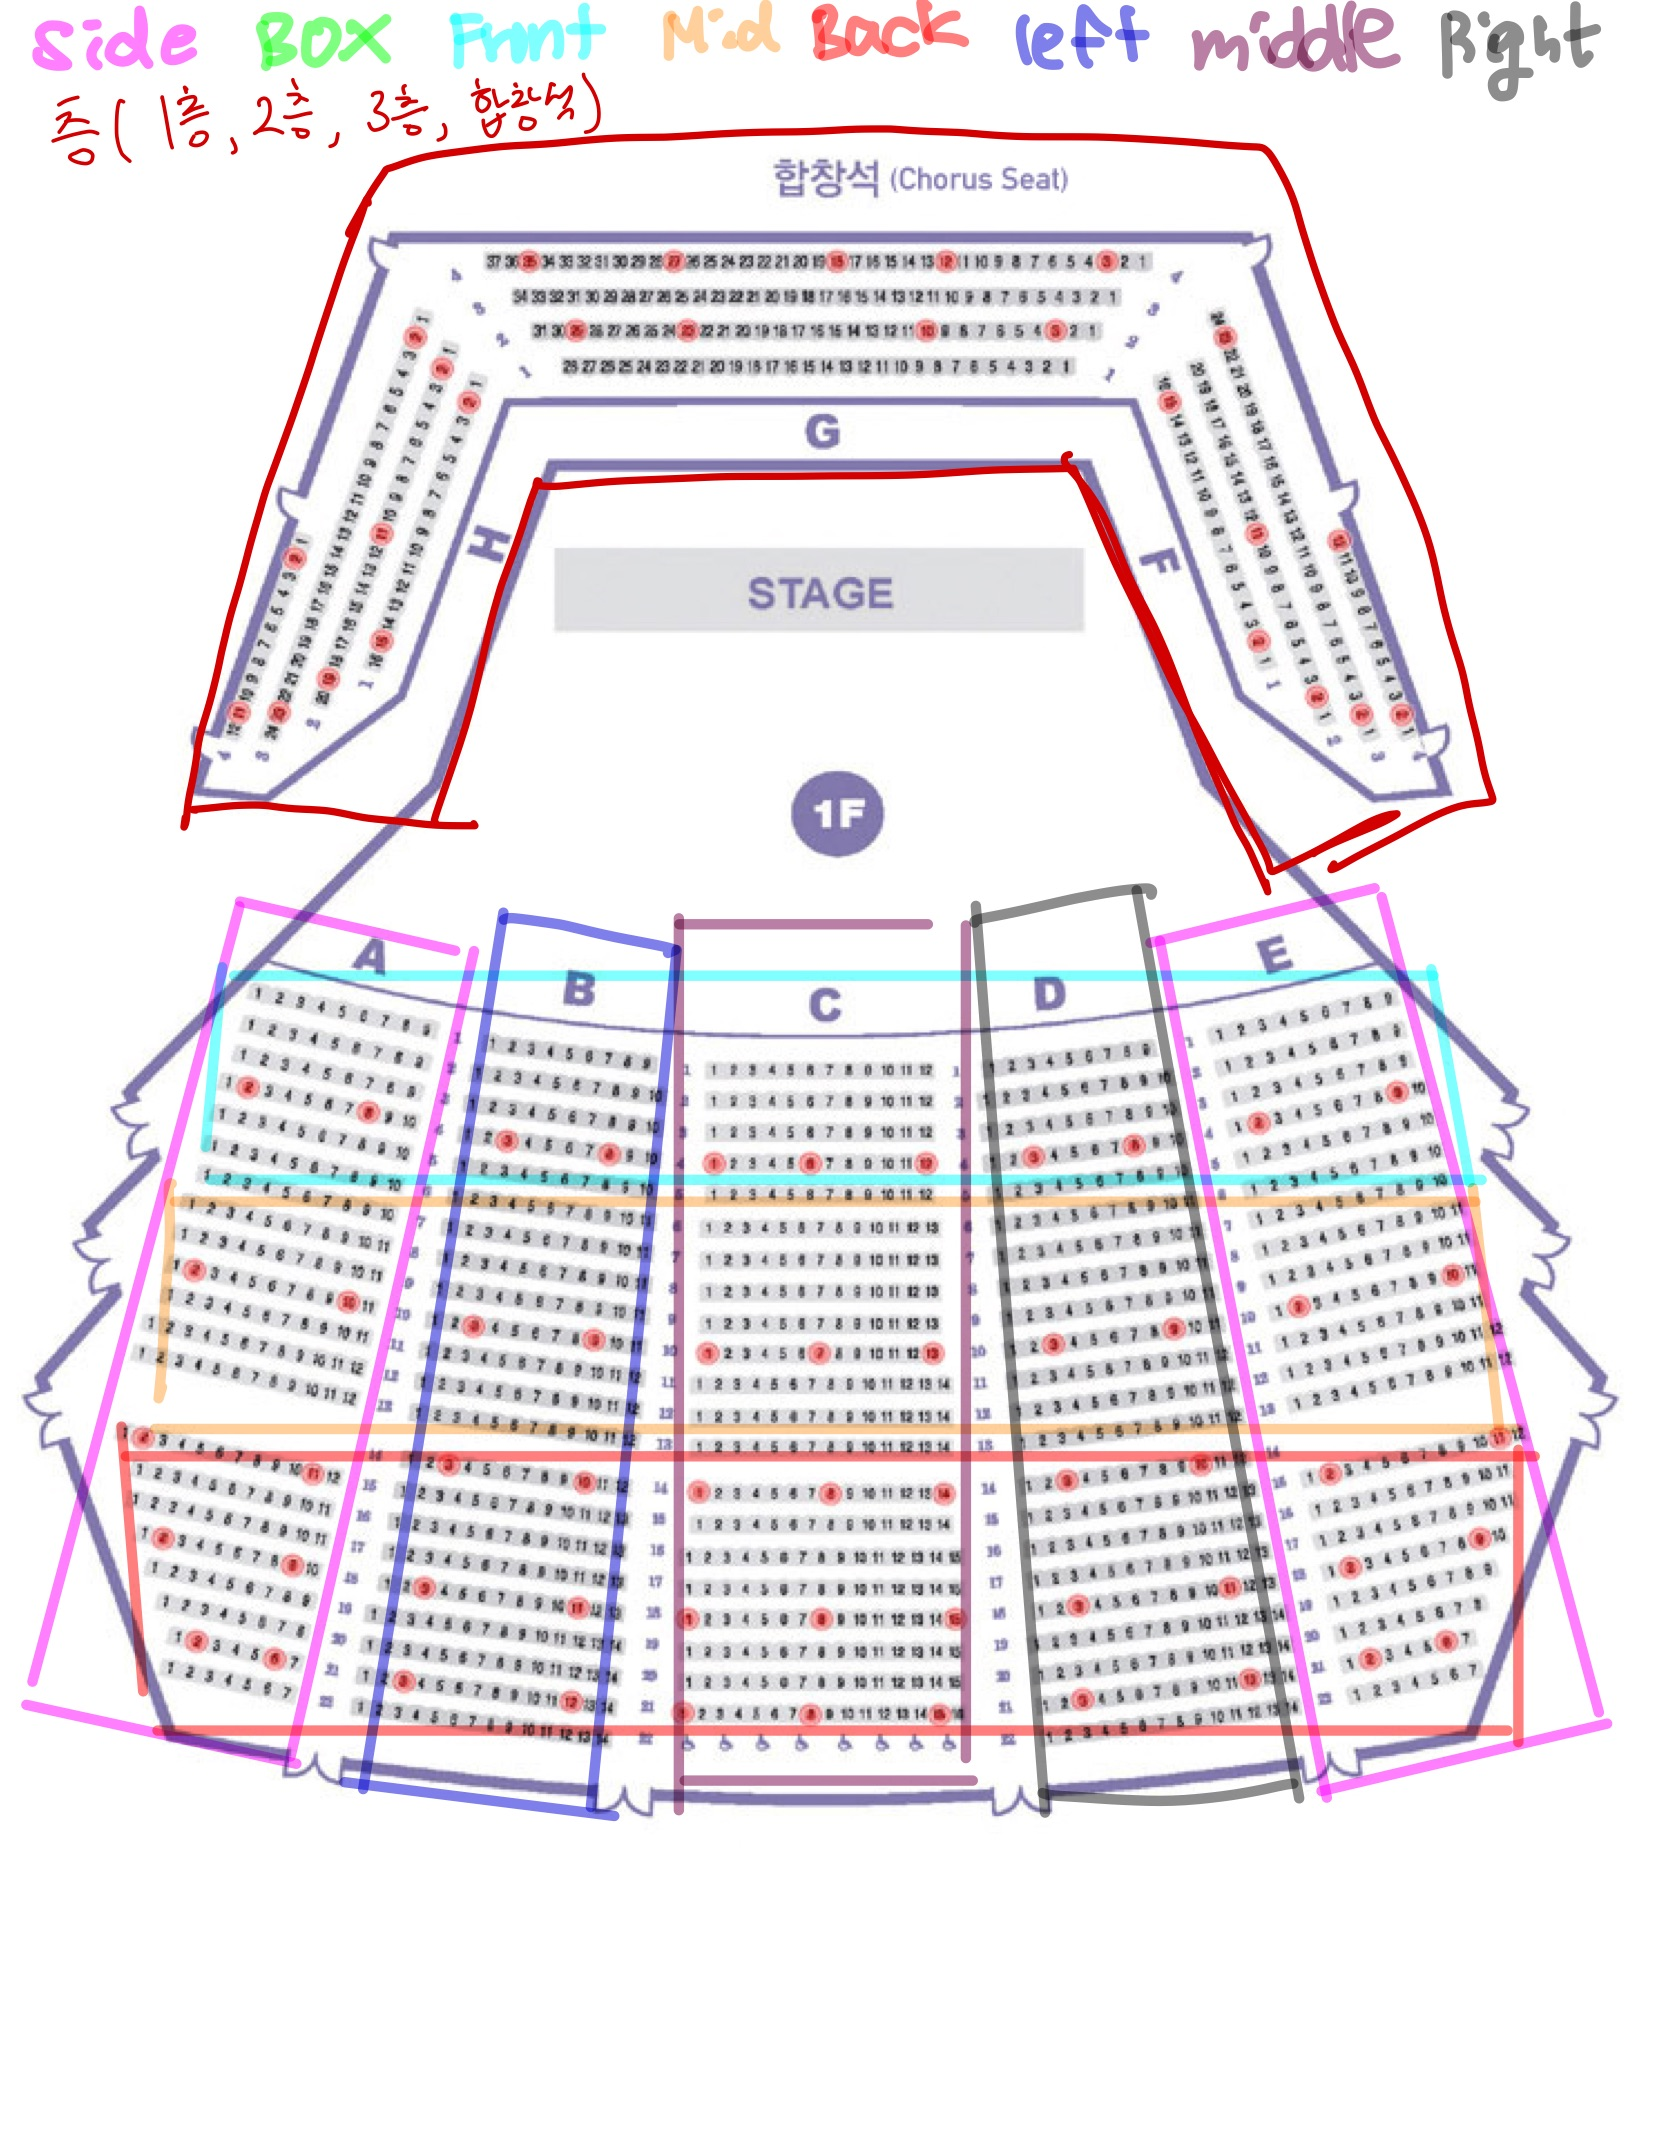

- BOX석

In [5]:
seat['BOX'] = seat['블록'].str.contains('BOX').astype(int)

- 사이드 블록
  - 1층 A,E블록 
  - 2층 A,E블록 
  - 3층 A,G블록

In [6]:
seat['side_seats'] = seat[['층','블록']].apply(lambda x: 1 if x[0] in ["1","2"] and x[1] in ['A','E'] else
                                                          1 if x[0] == "3" and x[1] in ['A','G'] else 0, axis=1)

- 왼쪽/중앙/오른쪽 블록

In [7]:
seat['middle'] = seat[['층','블록']].apply(lambda x: 1 if tuple(x) in [("1","C"),("2","C"),("3","D")] else 0, axis=1)
seat['left'] = seat[['층','블록']].apply(lambda x: 1 if tuple(x) in [("1","B"),("2","B"),("3","B"),("3","C")] else 0, axis=1)
seat['right'] = seat[['층','블록']].apply(lambda x: 1 if tuple(x) in [("1","D"),("2","D"),("3","E"),("3","F")] else 0, axis=1)

#### $\blacktriangleright$ 열

- BOX석 열 정보 생성

In [8]:
# BOX석의 열 정보를 클래식홀 배치도를 바탕으로 생성한다.
seat['좌석번호'] = seat['좌석번호'].astype(int)
box = seat[seat.블록.str.contains('BOX')]
box['열'] = box[['층','좌석번호']].apply(lambda x: (x[1]-1)//2+1 if x[0]=="2" else (x[1]-1)//3+1, axis=1)\
            .apply(lambda x: x if x <= 5 else None)
seat = pd.concat([seat.loc[[i for i in seat.index if i not in box.index]], box]).sort_index()

- 앞쪽/중간/뒤쪽 열

In [9]:
seat['열'] = seat['열'].astype(int)
seat['front'] = seat[['층','열']].apply(lambda x: 1 if x[0]=="1" and x[1] <= 5 else
                                                   1 if x[0]=="2" and x[1] <= 3 else
                                                   1 if x[0]=="3" and x[1] <= 5 else 0, axis=1)
seat['mid'] = seat[['층','열']].apply(lambda x: 1 if x[0]=="1" and 6 <= x[1] <= 13 else 0, axis=1)
seat['back'] = seat[['층','열']].apply(lambda x: 1 if x[0]=="1" and x[1] >= 14else
                                                   1 if x[0]=="2" and x[1] >= 4 else
                                                   1 if x[0]=="3" and x[1] >= 6 else 0, axis=1)

- 앞쪽 중앙열

In [10]:
seat['front_mid'] = seat[['층','블록','열']].apply(lambda x: 1 if x[0]=="1" and x[1] in ["B","C","D"] and x[2] <= 5 else 0, axis=1)

- 3층

In [11]:
# 3층 열들이 4부터 시작하는 것으로 되어있기에 1부터 시작하도록 바꾼다.
seat['열'] = seat[['층','블록','열']].apply(lambda x: x[2]-3 if x[0]=='3' and x[1] in ['B','C','D','E','F'] else x[2], axis=1)

- 블록 내 위치

In [12]:
ease = seat.groupby(['층','블록'])['열'].nunique().rename('블록길이')

# 클래식홀 전개도를 바탕으로 값 수정
ease.loc[[("1","A"),("1","E")]] = 22
ease = seat[['층','블록','열']].reset_index().merge(ease, on=['층','블록']).set_index('seat_label')
seat['row_ratio'] = ease['열']/ease['블록길이']

#### $\blacktriangleright$ 특수 좌석

- 피아노뷰 통로 좌석
  - 1층 B,C블록 통로 좌석 (8열~15열)
  - 2층 B블록 앞줄 왼쪽편 (1열~5열) 

In [13]:
seat['piano_hallway'] = seat[['층','블록','열','좌석번호']]\
                        .apply(lambda x: 1 if x[0]=="1" and x[1]=="B" and 8<=x[2]<=10 and 10<=x[3]<=11 else
                                          1 if x[0]=="1" and x[1]=="B" and 11<=x[2]<=14 and 11<=x[3]<=12 else
                                          1 if x[0]=="1" and x[1]=="B" and x[2]==15 and 12<=x[3]<=13 else
                                          1 if x[0]=="1" and x[1]=="C" and 8<=x[2]<=15 and 1<=x[3]<=2 else 0, axis=1)

- 풍부한 소리가 들리는 좌석

In [14]:
seat['sound_quality'] = seat[['층','블록','열']]\
                        .apply(lambda x: 1 if x[0]=="1" and x[1] in ["B","C","D"] and 8<=x[2]<=14 else 0, axis=1)

- 발을 뻗을 수 있는 좌석

In [15]:
seat['leg_free'] = seat[['층','블록','열']].apply(lambda x: 1 if x[0]=="1" and x[1] in ["A","E"] and x[2]==15 else 0, axis=1)

- 3층 시야방해좌석

In [16]:
seat['3rd_bad'] = seat[['층','블록']].apply(lambda x: 1 if x[0]=="3" and x[1] in ["N","M"] else 0, axis=1)

- 소리가 먹히는 좌석

In [17]:
seat['bad_sound'] = seat[['층','블록','열']]\
                    .apply(lambda x: 1 if x[0]=="1" and x[1] in ["A","B",'C','D','E'] and 17<=x[2]<=22 else 0, axis=1)

- 가수 얼굴이 보이는 좌석

In [18]:
seat['singer_face'] = seat[['층','블록','열']]\
                     .apply(lambda x: 1 if x[0]=="1" and x[1] in ["A","B","C","D"] and x[2]<=5 else 0, axis=1)

- 지휘자 등만보는좌석

In [19]:
seat['conductor_back'] = seat[['층','블록']].apply(lambda x: 1 if x[0]=="2" and x[1]=="E" else 0, axis=1)

## Merge data

In [20]:
data = pd.merge(data.drop(['층','블록','열','좌석번호'], axis=1), seat.reset_index(), on='seat_label')
print(f'데이터 크기: {data.shape}')

데이터 크기: (924321, 66)


## Save data

In [21]:
data.to_parquet('../data/DataCleansing.pqt')